# Specifying Centroids for CVTArchive

_This tutorial is part of the series of pyribs tutorials! See [here](https://docs.pyribs.org/en/latest/tutorials.html) for the list of all tutorials and the order in which they should be read._

In the [CVTArchive](https://docs.pyribs.org/en/latest/api/ribs.archives.CVTArchive.html), the cells are defined by centroids, which are points in measure space that form the center of each cell. By default, centroids are generated by sampling points within the bounds of the measure space and performing $k$-means clustering on them. This tutorial dives a bit deeper into how to specify centroids and demonstrates several alternative methods for centroid generation.

## Setup

In [ ]:
%pip install ribs[visualize]

In [ ]:
import numpy as np

from ribs.archives import CVTArchive
from ribs.visualize import cvt_archive_heatmap

## Default Centroid Generation

As mentioned above, the default centroid generation method involves running $k$-means clustering on randomly sampled points in the measure space. We can create and visualize the cells in such an archive as follows.

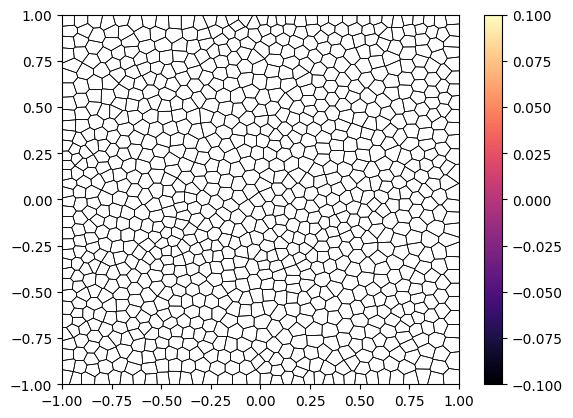

In [2]:
archive = CVTArchive(
    solution_dim=10,
    centroids=1000,
    ranges=[(-1, 1), (-1, 1)],
)

cvt_archive_heatmap(archive)

We can also view the centroids with the `plot_centroids` parameter:

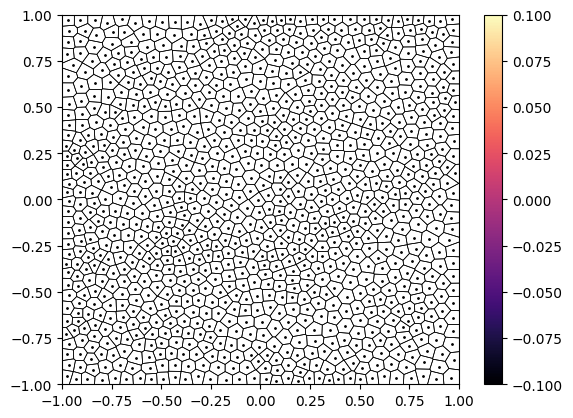

In [3]:
cvt_archive_heatmap(archive, plot_centroids=True)

## Manually Passing in Centroids

In addition to automatically generating centroids, it is possible to pass them in as an array:

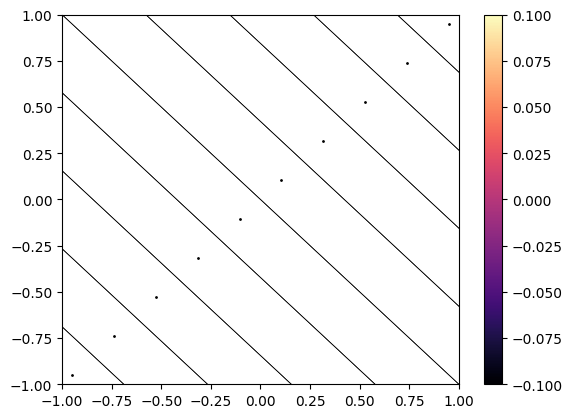

In [4]:
centroids = np.stack(
    (np.linspace(-0.95, 0.95, 10), np.linspace(-0.95, 0.95, 10)), axis=1
)

archive = CVTArchive(
    solution_dim=10,
    centroids=centroids,
    ranges=[(-1, 1), (-1, 1)],
)

cvt_archive_heatmap(archive, plot_centroids=True)

This can be useful, for instance, if we would like to reuse centroids across archives. Here, `archive2` uses the centroids from `archive`:

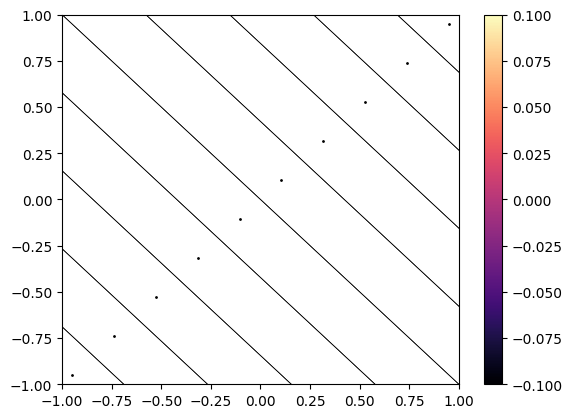

In [5]:
archive2 = CVTArchive(
    solution_dim=10,
    centroids=archive.centroids,
    ranges=[(-1, 1), (-1, 1)],
)

cvt_archive_heatmap(archive2, plot_centroids=True)

## Running k-means Clustering and Sharing Centroids Across Experiments

Internally, `CVTArchive` depends on the [k_means_centroids](https://docs.pyribs.org/en/latest/api/ribs.archives.k_means_centroids.html) function for generating centroids. `k_means_centroids` randomly samples points within the measure space and clusters them with $k$-means clustering. Below we show an example of using `k_means_centroids`:

In [6]:
from ribs.archives import k_means_centroids

centroids, _ = k_means_centroids(
    centroids=1000,
    ranges=[(-1, 1), (-1, 1)],
    samples=100_000,  # Sample 100,000 points within the measure space.
    dtype=np.float32,
    seed=42,
)

This can be useful, for instance, if we want to save the centroids to a file so that they can be shared across experiments:

In [7]:
np.save("centroids.npy", centroids)

Then when we wish to create an archive, we can load the centroids from the file. Note that we support passing the file name directly to `CVTArchive`, in which case it is read with [np.load](https://numpy.org/doc/stable/reference/generated/numpy.load.html).

In [8]:
archive = CVTArchive(
    solution_dim=10,
    centroids="centroids.npy",
    ranges=[(-1, 1), (-1, 1)],
    dtype=np.float32,
)

archive2 = CVTArchive(
    solution_dim=10,
    centroids="centroids.npy",
    ranges=[(-1, 1), (-1, 1)],
    dtype=np.float32,
)

# Double-check that the centroids we loaded are identical in both archives.
assert np.all(archive.centroids == archive2.centroids)

## Alternative Generation Methods

[Mouret 2023](https://dl.acm.org/doi/pdf/10.1145/3583133.3590726) present alternatives to the aforementioned $k$-means clustering approach. Here we show how to integrate those methods with the CVTArchive.

### Random Sampling

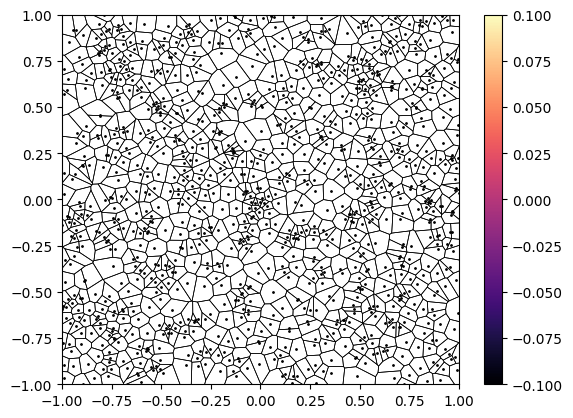

In [9]:
seed = 42
rng = np.random.default_rng(seed)
centroids = rng.uniform(
    # Note that the ranges here are lower bounds and then upper bounds, while the
    # archive ranges argument expects a range for each measure dimension. That is
    # to say, these are [-1, -1] and [1, 1], instead of [-1, 1] and [-1, 1].
    [-1, -1],
    [1, 1],
    size=(1000, 2),
)

archive = CVTArchive(
    solution_dim=10,
    centroids=centroids,
    ranges=[(-1, 1), (-1, 1)],
)

cvt_archive_heatmap(archive, plot_centroids=True)

### Sobol Sampling

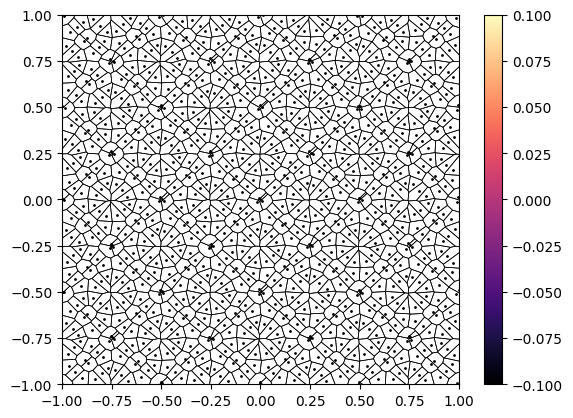

In [10]:
from scipy.stats.qmc import Sobol

# Generates centroids with a Sobol sequence --- Sobol sequences expect n to be a
# power of 2, so this uses 1024 cells instead of 1000. Also, d=2 refers to the
# dimensionality of the measure space.
sampler = Sobol(d=2, scramble=False)
sobol_nums = sampler.random(n=1024)
# Similar to the random centroids example, we use the bounds of the archive
# here, rather than the ranges.
centroids = np.asarray([-1, -1]) + sobol_nums * (
    np.asarray([1, 1]) - np.asarray([-1, -1])
)

archive = CVTArchive(
    solution_dim=10,
    centroids=centroids,
    ranges=[(-1, 1), (-1, 1)],
)

cvt_archive_heatmap(archive, plot_centroids=True)

### Scrambled Sobol Sampling

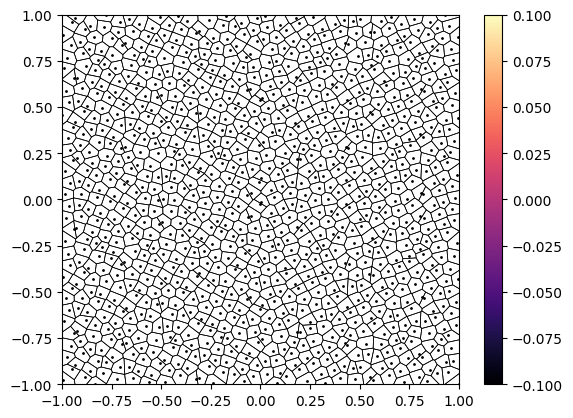

In [11]:
from scipy.stats.qmc import Sobol

# Generates centroids as a scrambled Sobol sequence. This is identical to the
# last example, but with scramble=True now.
seed = 42
sampler = Sobol(d=2, scramble=True, rng=seed)
sobol_nums = sampler.random(n=1024)
centroids = np.asarray([-1, -1]) + sobol_nums * (
    np.asarray([1, 1]) - np.asarray([-1, -1])
)

archive = CVTArchive(
    solution_dim=10,
    centroids=centroids,
    ranges=[(-1, 1), (-1, 1)],
)

cvt_archive_heatmap(archive, plot_centroids=True)

### Halton Sequence

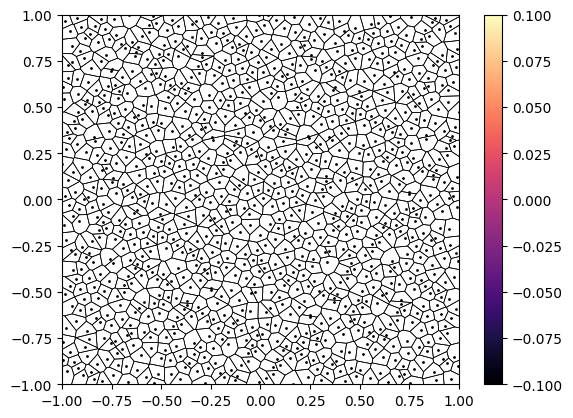

In [12]:
from scipy.stats.qmc import Halton

# Generates centroids with a Halton sequence.
seed = 42
sampler = Halton(d=2, rng=seed)
halton_nums = sampler.random(n=1000)
centroids = np.asarray([-1, -1]) + halton_nums * (
    np.asarray([1, 1]) - np.asarray([-1, -1])
)

archive = CVTArchive(
    solution_dim=10,
    centroids=centroids,
    ranges=[(-1, 1), (-1, 1)],
)

cvt_archive_heatmap(archive, plot_centroids=True)